# Objective

The objective of this notebook is to compare bispecific T cell engagers (BiTEs) based on target concentrations and binding dissociation rates.

In [1]:
using DifferentialEquations, Plots, Plots.PlotMeasures

default(; # Plots defaults
    fontfamily="Computer modern"
    )

# Steady state response

Drug concentration in the tme is $C_t$, $T1_t$ is the immune cell receptor, and $T2_t$ is the tumor protein.

$
\begin{align}
\dot{C} &  = - k_{n1} T1 C - k_{n2} T2 C + k_{f1} D1 + k_{f2} D2,\\
        \dot{T1} & = - k_{n1} T1 C + k_{f1} D1 - k_{n1} T1 D2 + k_{f1} Trimer,\\
        \dot{T2} & = - k_{n2} T2 C + k_{f2} D2 - k_{n2} T2 D1 + k_{f2} Trimer,\\
        \dot{D1} & = k_{n1} T1 C - k_{f1} D1 - k_{n2} T2 D1 + k_{f2} Trimer ,\\
        \dot{D2} & = k_{n2} T2 C + k_{f2} D2 - k_{n1} T1 D2 + k_{f1} Trimer,\\
        \dot{Trimer} & = k_{n1} T1 D2 + k_{n2} T2 D1 - (k_{f1}+k_{f2}) Trimer.
\end{align}
$

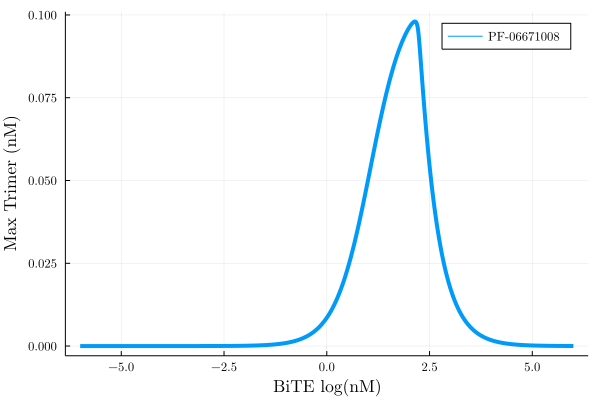

In [2]:
function TME(du,u,p,t)
    Cₜ, T1ₜ, T2ₜ, D1ₜ, D2ₜ, Rₜ = u
    kn₁, kf₁, kn₂, kf₂ = p 
    du[1]= -kn₁*T1ₜ*Cₜ -kn₂*T2ₜ*Cₜ +kf₁*D1ₜ +kf₂*D2ₜ
    du[2]= -kn₁*T1ₜ*Cₜ +kf₁*D1ₜ -kn₁*T1ₜ*D2ₜ +kf₁*Rₜ
    du[3]= -kn₂*T2ₜ*Cₜ +kf₂*D2ₜ -kn₂*T2ₜ*D1ₜ +kf₂*Rₜ
    du[4]= +kn₁*T1ₜ*Cₜ -kf₁*D1ₜ -kn₂*T2ₜ*D1ₜ +kf₂*Rₜ
    du[5]= +kn₂*T2ₜ*Cₜ -kf₂*D2ₜ -kn₁*T1ₜ*D2ₜ +kf₁*Rₜ
    du[6]= +kn₁*T1ₜ*D2ₜ +kn₂*T2ₜ*D1ₜ -(kf₁+kf₂)*Rₜ
end

x0 = [1e0,1.08e-1,166,0.0,0.0,0.0]
ts = (0.0,0.5)
kd = [1.72,19.66,1.57,0.74]
TMEproblem  = ODEProblem(TME,x0,ts,kd)

function bellshape(problem,kds,initial)
    kd = [1,kds[1],1,kds[2]] # kon values doesn't matter
    x0 = [0,initial[1],initial[2],0,0,0]
    xx = range(-6,+6,length=10000) # x axis limits
    ss = zeros(length(xx))
    dose = 10 .^xx
    problem_ = remake(problem, tspan=(0.0,1e4), p=kd, u0=x0)
    for index=1:length(dose) 
        iteration = remake(problem_, u0=vcat(dose[index], problem.u0[2:end]))
        solution  = solve(iteration)
        ss[index] = solution[6,end]'
    end
    return [xx, ss]
end

xx, ss = bellshape(TMEproblem, [11.5, 0.521],[1.08e-1,166])
plot(xx,ss, label="PF-06671008", linewidth=4, xlabel="BiTE log(nM)", ylabel="Max Trimer (nM)")

## Comparison

In [31]:
function compare(problem)
    bl = bellshape(problem, [260., 1.49] ,[1.08e-1,166]) # Blinatumomab
    so = bellshape(problem, [16.0, 77.0] ,[1.08e-1,166]) # Solitomab
    pf = bellshape(problem, [11.5, 0.521],[1.08e-1,166]) # PF-06671008
    fl = bellshape(problem, [37, 0.049]  ,[1.08e-1,166]) # CD3-FLT3 (7370)
    am = bellshape(problem, [4.6 , 3.0]  ,[1.08e-1,166]) # CD3-DDL3 (AMG757)
    ro = bellshape(problem, [42, 4.2]    ,[1.08e-1,166]) # CD3-ROR1 (VL1.07VH1.01)
    p1 = plot(bl[1],bl[2], label="Blinatumomab", linewidth=3, legend=:left,
        xlabel="BiTE log(nM)", ylabel="Max Trimer (nM)", title="Bell-Shapes")
    p1 = plot!(p1,so[1], so[2], label="Solitomab", linewidth=3)
    p1 = plot!(p1,pf[1], pf[2], label="PF-06671008", linewidth=3)
    p1 = plot!(p1,fl[1], fl[2], label="CD3-FLT3", linewidth=3)
    p1 = plot!(p1,am[1], am[2], label="CD3-DDL3", linewidth=3)
    p1 = plot!(p1,ro[1], ro[2], label="CD3-ROR1", linewidth=3)

    p2 = plot(bl[1],100 .*bl[2]./maximum(bl[2]), label="Blinatumomab", linewidth=3, legend=:left,
        xlabel="BiTE log(nM)", ylabel="Normalized Max Trimer (%)", title="Normalized Bell-Shapes")
    p2 = plot!(p2,so[1], 100 .*so[2]./maximum(so[2]), label="Solitomab", linewidth=3)
    p2 = plot!(p2,pf[1], 100 .*pf[2]./maximum(pf[2]), label="PF-06671008", linewidth=3)
    p2 = plot!(p2,fl[1], 100 .*fl[2]./maximum(fl[2]), label="CD3-FLT3", linewidth=3)
    p2 = plot!(p2,am[1], 100 .*am[2]./maximum(am[2]), label="CD3-DDL3", linewidth=3)
    p2 = plot!(p2,ro[1], 100 .*ro[2]./maximum(ro[2]), label="CD3-ROR1", linewidth=3)
    p  = plot(p1,p2, layout=(1,2), size=(900,300), margin=5mm)
    savefig(p, "compare1.png")
    savefig(p, "compare1.pdf")
    display(p)
end

compare(TMEproblem)

# Optimal antibody concentration



In [30]:
# identify maximum trimer value and drug dose
function optimal(problem,kds,initial)
    long = bellshape(problem,kds,initial)
    dose = 10 .^long[1] 
    value, index = findmax(long[2])
    return [value, dose[index]]
end

optimal(TMEproblem, [11.5, 0.521],[1.08e-1,166])

2-element Vector{Float64}:
   0.09800657518583002
 139.32030015451159

## Sweep dissociation rates

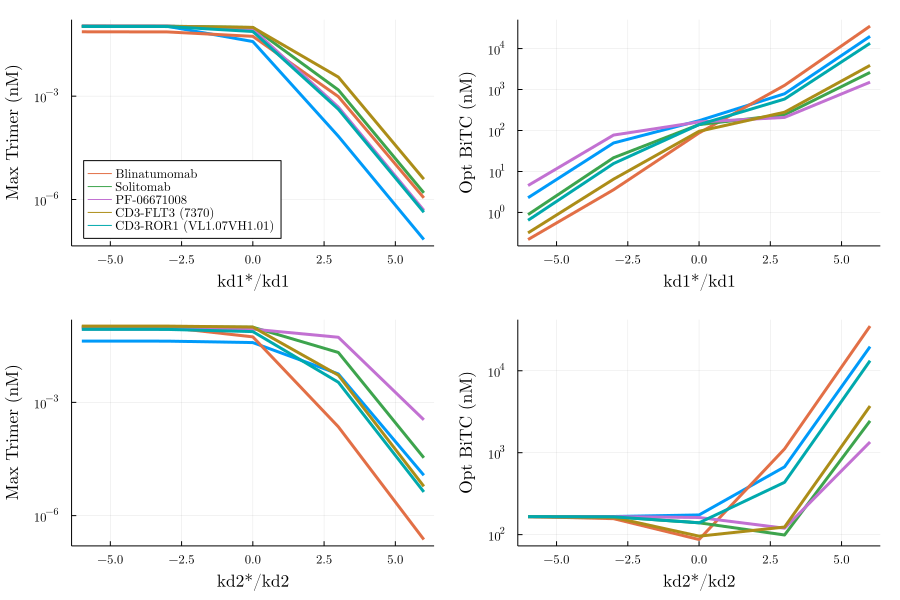

In [84]:
function d2c(problem,kds,initials)
    resolution = 5
    xxaxis = range(-6,6,length=resolution)
    trimer = zeros(2,resolution)
    opdrug = zeros(2,resolution)
    drange = 10 .^xxaxis
    for index = 1:resolution
        trimer[1,index], opdrug[1,index] = optimal(problem, [drange[index]*kds[1], kds[2]],initial)
        trimer[2,index], opdrug[2,index] = optimal(problem, [kds[1], drange[index]*kds[2]],initial)
    end
    return [xxaxis, opdrug, trimer]
end

function sweepkd(problem)
    bl = d2c(problem, [260., 1.49] ,[1.08e-1,166]) # Blinatumomab
    so = d2c(problem, [16.0, 77.0] ,[1.08e-1,166]) # Solitomab
    pf = d2c(problem, [11.5, 0.521],[1.08e-1,166]) # PF-06671008
    fl = d2c(problem, [37, 0.049]  ,[1.08e-1,166]) # CD3-FLT3 (7370)
    am = d2c(problem, [4.6 , 3.0]  ,[1.08e-1,166]) # CD3-DDL3 (AMG757)
    ro = d2c(problem, [42, 4.2]    ,[1.08e-1,166]) # CD3-ROR1 (VL1.07VH1.01)
    p1 = plot(bl[1],bl[3][1,:], ylabel="Max Trimer (nM)", linewidth=3, label=:false, xlabel="kd1*/kd1", yaxis=:log)
    p1 = plot!(p1,so[1],so[3][1,:],linewidth=3, label="Blinatumomab", legend=:bottomleft)
    p1 = plot!(p1,pf[1],pf[3][1,:],linewidth=3, label="Solitomab")
    p1 = plot!(p1,fl[1],fl[3][1,:],linewidth=3, label="PF-06671008")
    p1 = plot!(p1,am[1],am[3][1,:],linewidth=3, label="CD3-FLT3 (7370)")
    p1 = plot!(p1,ro[1],ro[3][1,:],linewidth=3, label="CD3-ROR1 (VL1.07VH1.01)")
    p2 = plot(bl[1],bl[2][1,:], ylabel="Opt BiTC (nM)", linewidth=3, label=:false, xlabel="kd1*/kd1", yaxis=:log)
    p2 = plot!(p2,so[1],so[2][1,:],linewidth=3, label=:false)
    p2 = plot!(p2,pf[1],pf[2][1,:],linewidth=3, label=:false)
    p2 = plot!(p2,fl[1],fl[2][1,:],linewidth=3, label=:false)
    p2 = plot!(p2,am[1],am[2][1,:],linewidth=3, label=:false)
    p2 = plot!(p2,ro[1],ro[2][1,:],linewidth=3, label=:false)
    p3 = plot(bl[1],bl[3][2,:], ylabel="Max Trimer (nM)", linewidth=3, label=:false, xlabel="kd2*/kd2", yaxis=:log)
    p3 = plot!(p3,so[1],so[3][2,:],linewidth=3, label=:false)
    p3 = plot!(p3,pf[1],pf[3][2,:],linewidth=3, label=:false)
    p3 = plot!(p3,fl[1],fl[3][2,:],linewidth=3, label=:false)
    p3 = plot!(p3,am[1],am[3][2,:],linewidth=3, label=:false)
    p3 = plot!(p3,ro[1],ro[3][2,:],linewidth=3, label=:false)
    p4 = plot(bl[1],bl[2][2,:], ylabel="Opt BiTC (nM)", linewidth=3, label=:false, xlabel="kd2*/kd2", yaxis=:log)
    p4 = plot!(p4,so[1],so[2][2,:],linewidth=3, label=:false)
    p4 = plot!(p4,pf[1],pf[2][2,:],linewidth=3, label=:false)
    p4 = plot!(p4,fl[1],fl[2][2,:],linewidth=3, label=:false)
    p4 = plot!(p4,am[1],am[2][2,:],linewidth=3, label=:false)
    p4 = plot!(p4,ro[1],ro[2][2,:],linewidth=3, label=:false)
    p = plot(p1,p2,p3,p4,layout=(2,2), size=(900,600), margin=3mm) 
    savefig(p, "compare2.png")
    savefig(p, "compare2.pdf")
    return p
end

sweepkd(TMEproblem)

## Sweep target concentrations

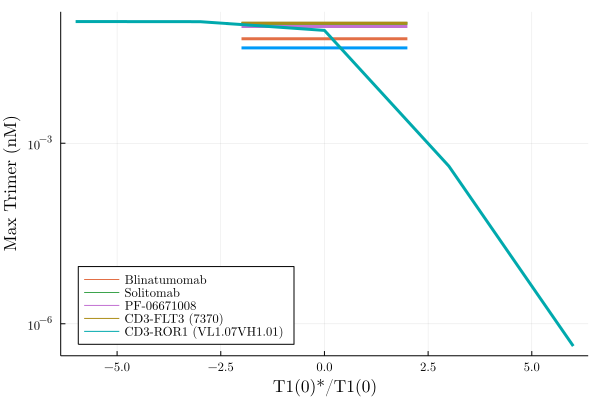

In [89]:
function s2c(problem,kds,t0)
    resolution = 5
    xxaxis = range(-2,2,length=resolution)
    trimer = zeros(2,resolution)
    opdrug = zeros(2,resolution)
    drange = 10 .^xxaxis
    for index = 1:resolution
        trimer[1,index], opdrug[1,index] = optimal(problem, kds, [drange[index]*t0[1], t0[2]])
        trimer[2,index], opdrug[2,index] = optimal(problem, kds, [t0[1], drange[index]*t0[2]])
    end
    return [xxaxis, opdrug, trimer]
end

function sweept0(problem)
    bl = s2c(problem, [260., 1.49] ,[1.08e-1,166]) # Blinatumomab
    so = s2c(problem, [16.0, 77.0] ,[1.08e-1,166]) # Solitomab
    pf = s2c(problem, [11.5, 0.521],[1.08e-1,166]) # PF-06671008
    fl = s2c(problem, [37, 0.049]  ,[1.08e-1,166]) # CD3-FLT3 (7370)
    am = s2c(problem, [4.6 , 3.0]  ,[1.08e-1,166]) # CD3-DDL3 (AMG757)
    ro = d2c(problem, [42, 4.2]    ,[1.08e-1,166]) # CD3-ROR1 (VL1.07VH1.01)
    p1 = plot(bl[1],bl[3][1,:], ylabel="Max Trimer (nM)", linewidth=3, 
        legend=:bottomleft, label=:false, xlabel="T1(0)*/T1(0)", yaxis=:log)
    p1 = plot!(p1,so[1],so[3][1,:],linewidth=3, label="Blinatumomab")
    p1 = plot!(p1,pf[1],pf[3][1,:],linewidth=3, label="Solitomab")
    p1 = plot!(p1,fl[1],fl[3][1,:],linewidth=3, label="PF-06671008")
    p1 = plot!(p1,am[1],am[3][1,:],linewidth=3, label="CD3-FLT3 (7370)")
    p1 = plot!(p1,ro[1],ro[3][1,:],linewidth=3, label="CD3-ROR1 (VL1.07VH1.01)")
#     p2 = plot(bl[1],bl[2][1,:], ylabel="Opt BiTC (nM)", linewidth=3, 
#         label=:false, xlabel="T1(0)*/T1(0)", yaxis=:log)
#     p2 = plot!(p2,so[1],so[2][1,:],linewidth=3, label=:false)
#     p2 = plot!(p2,pf[1],pf[2][1,:],linewidth=3, label=:false)
#     p2 = plot!(p2,fl[1],fl[2][1,:],linewidth=3, label=:false)
#     p2 = plot!(p2,am[1],am[2][1,:],linewidth=3, label=:false)
#     p2 = plot!(p2,ro[1],ro[2][1,:],linewidth=3, label=:false)
#     p3 = plot(bl[1],bl[3][2,:], ylabel="Max Trimer (nM)", linewidth=3, 
#         label=:false, xlabel="T2(0)*/T2(0)", yaxis=:log)
#     p3 = plot!(p3,so[1],so[3][2,:],linewidth=3, label=:false)
#     p3 = plot!(p3,pf[1],pf[3][2,:],linewidth=3, label=:false)
#     p3 = plot!(p3,fl[1],fl[3][2,:],linewidth=3, label=:false)
#     p3 = plot!(p3,am[1],am[3][2,:],linewidth=3, label=:false)
#     p3 = plot!(p3,ro[1],ro[3][2,:],linewidth=3, label=:false)
#     p4 = plot(bl[1],bl[2][2,:], ylabel="Opt BiTC (nM)", linewidth=3, 
#         label=:false, xlabel="T2(0)*/T2(0)", yaxis=:log)
#     p4 = plot!(p4,so[1],so[2][2,:],linewidth=3, label=:false)
#     p4 = plot!(p4,pf[1],pf[2][2,:],linewidth=3, label=:false)
#     p4 = plot!(p4,fl[1],fl[2][2,:],linewidth=3, label=:false)
#     p4 = plot!(p4,am[1],am[2][2,:],linewidth=3, label=:false)
#     p4 = plot!(p4,ro[1],ro[2][2,:],linewidth=3, label=:false)
#     p = plot(p1,p2,p3,p4,layout=(2,2), size=(900,600), margin=3mm) 
#     savefig(p, "compare3.png")
#     savefig(p, "compare3.pdf")
    return p1
end

sweept0(TMEproblem)

# Heatmaps

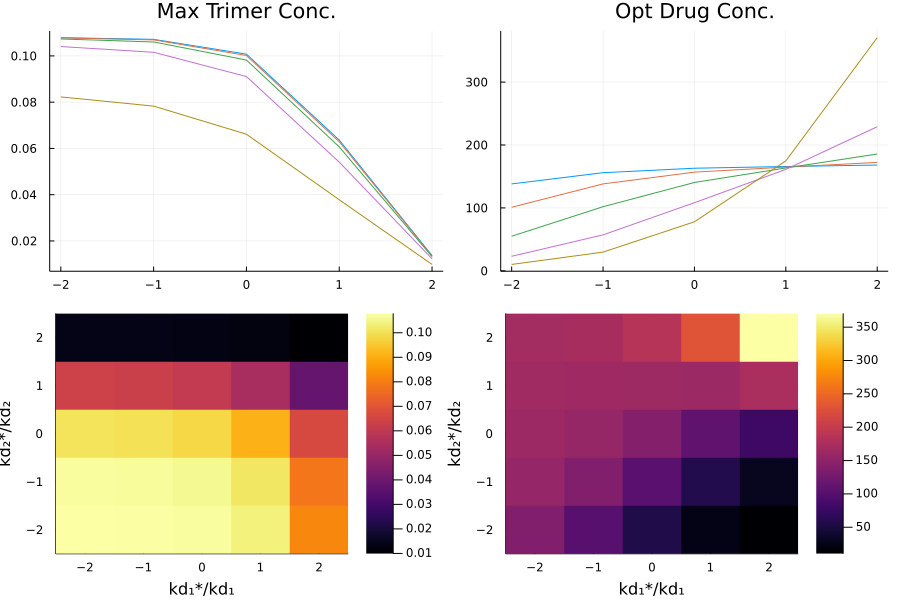

In [10]:
function dismap(problem)
    resolution = 5
    trimer = zeros(resolution,resolution)
    opdrug = zeros(resolution,resolution)
    vector = range(-2,2,length=resolution)
    drange = 10 .^ vector
    for i1 = 1:resolution
        for i2 = 1:resolution
            problem_ = remake(problem, p =vcat(problem.p[1], 
                    drange[i1]*problem.p[2], problem.p[3],
                    drange[i2]*problem.p[4], problem.p[5:end]))
            trimer[i1,i2], opdrug[i1,i2] = optimal(problem_,6)
        end
    end
    p1 = plot(vector,trimer,label=:false, title="Max Trimer Conc.")
    p2 = plot(vector,opdrug,label=:false, title="Opt Drug Conc.")
    q1  = plot(p1,p2, layout=(1,2))
    savefig(q1, "TME_8.png")
    p3 = heatmap(vector,vector,trimer,cgrad=:log, ylabel="kd2*/kd2", xlabel="kd₁*/kd₁")
    p4 = heatmap(vector,vector,opdrug,cgrad=:log, ylabel="kd2*/kd2", xlabel="kd₁*/kd₁")
    q2  = plot(p3,p4, layout=(1,2))
    savefig(q2, "TME_9.png")
    q = plot(q1, q2, layout=(2,1), size=(900,600))
end

dismap(TMEproblem)

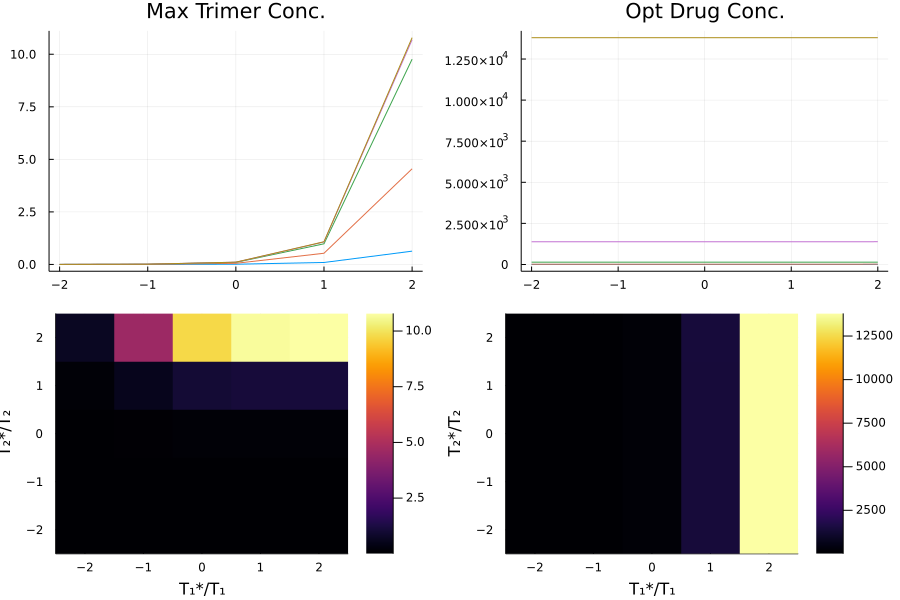

In [11]:
function conmap(problem)
    resolution = 5
    trimer = zeros(resolution,resolution)
    opdrug = zeros(resolution,resolution)
    vector = range(-2,2,length=resolution)
    drange = 10 .^ vector
    for i1 = 1:resolution
        for i2 = 1:resolution
            problem_ = remake(problem, u0=vcat(problem.u0[1], 
                    drange[i1]*problem.u0[2], drange[i2]*problem.u0[3],
                    problem.u0[4:end]))
            trimer[i1,i2], opdrug[i1,i2] = optimal(problem_,6)
        end
    end
    p1 = plot(vector,trimer,label=:false, title="Max Trimer Conc.")
    p2 = plot(vector,opdrug,label=:false, title="Opt Drug Conc.")
    q1  = plot(p1,p2, layout=(1,2))
    savefig(q1, "TME_10.png")
    p3 = heatmap(vector,vector,trimer,cgrad=:log, ylabel="T₂*/T₂", xlabel="T₁*/T₁")
    p4 = heatmap(vector,vector,opdrug,cgrad=:log, ylabel="T₂*/T₂", xlabel="T₁*/T₁")
    q2  = plot(p3,p4, layout=(1,2))
    savefig(q2, "TME_11.png")
    q = plot(q1, q2, layout=(2,1), size=(900,600))
end

conmap(TMEproblem)

# Adjourn

In [12]:
using Dates
println("mahdiar")
Dates.format(now(), "Y/U/d HH:MM")

mahdiar


"2021/December/2 10:38"